In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import statistics as stat
from enhancement_analysis import *
from fit_functions import *
from low_level import readCSVrows,writeCSVrows,calcEnhancement
%matplotlib inline

First, Chirp analysis

In [69]:
results=readCSVcolumns('Processed_20190315/data_legend_chirp.csv',skip_header=1)
header = results[1]
print(header)
[powers_chirp,starts_chirp,stops_chirp]= results[0]

Done! Array read from Processed_20190315/data_legend_chirp.csv
[['ï»¿Power (mW)', 'Start File', 'Stop File']]


FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

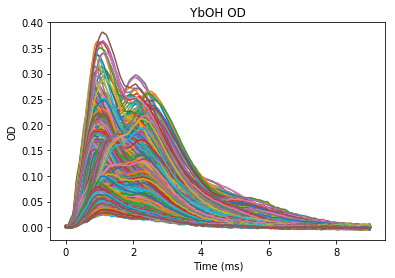

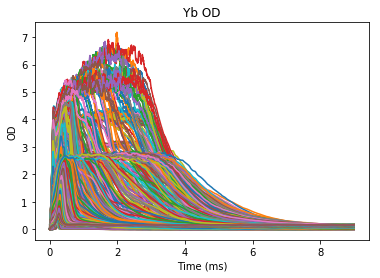

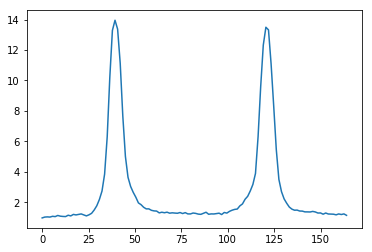

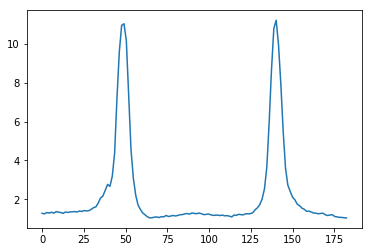

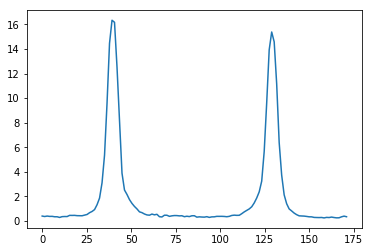

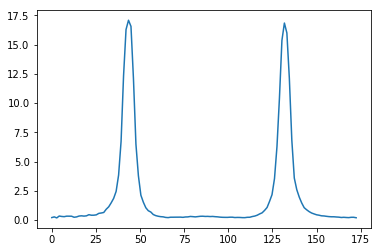

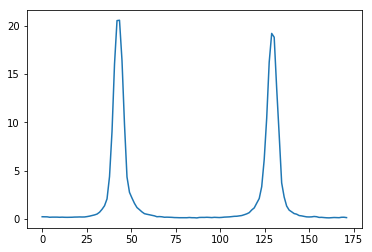

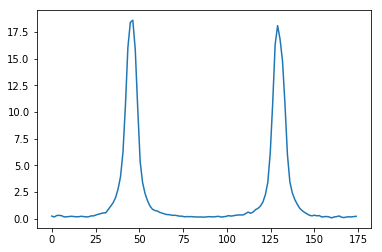

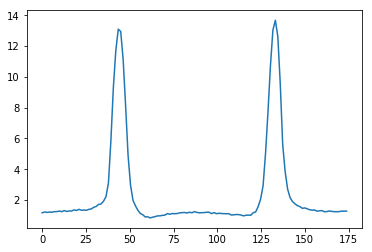

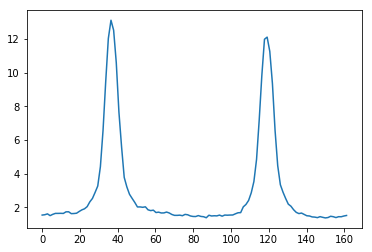

In [70]:
folder = '20190315'
skips=[]
ABAB = True

b_ODs = []
ub_ODs = []

for start,stop,p in zip(starts_chirp.astype(int),stops_chirp.astype(int),powers_chirp):
    ODs_1 = calculateSeriesOD(folder,start,stop,skips,ABAB=ABAB)
    ODs_2 = calculateSeriesOD(folder,start+1,stop,skips,ABAB=ABAB)
    
    p_1 = processData(ODs_1,[0,9])
    p_2 = processData(ODs_2,[0,9])
    
    plt.figure()
    plt.plot(p_1[2],p_1[1],label='i={}'.format(p))
    
    b,ub = identifyBUB(p_1,p_2)
    b_ODs.append(b)
    ub_ODs.append(ub)
#p=YbOH integrated, Yb integrated, timestamp

118
57
61
118
118
57
61
118
131
67
64
131
130
66
64
130
122
60
62
122
123
60
63
123


D:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


124
62
62
124
124
63
61
124
123
61
62
123
123
61
62
123
124
62
62
124
125
63
62
125
125
63
62
125
125
63
62
125
[0.98868112]
6 0
115
55
60
115
116
56
60
116
[0.96528326 0.97872758 0.93811349 0.88921072 0.93416997 0.70904381]
7 1


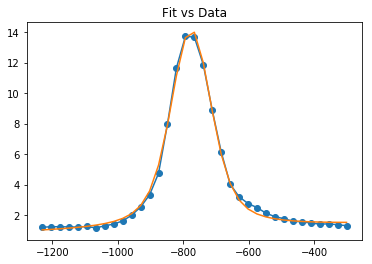

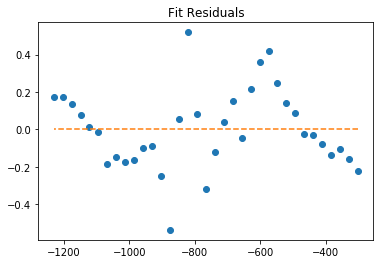

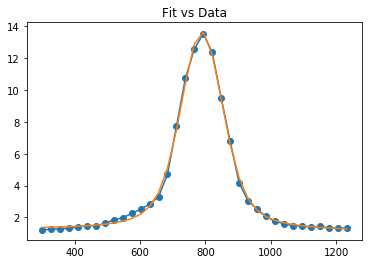

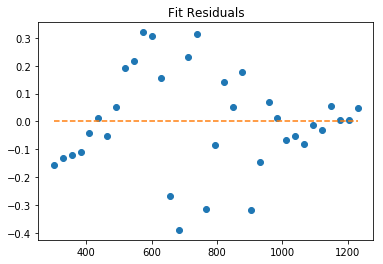

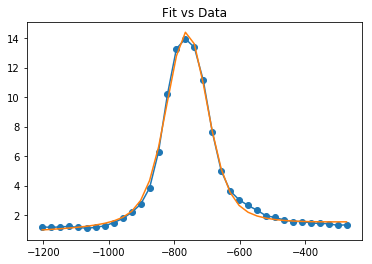

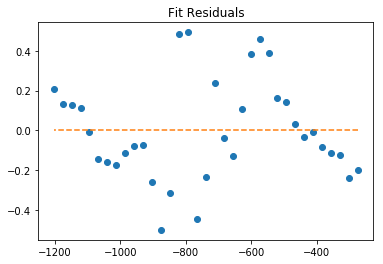

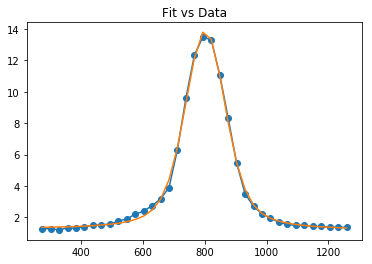

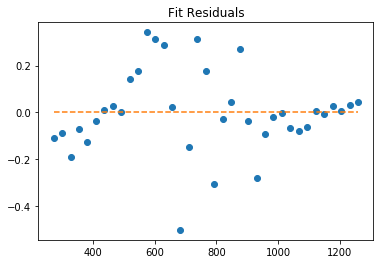

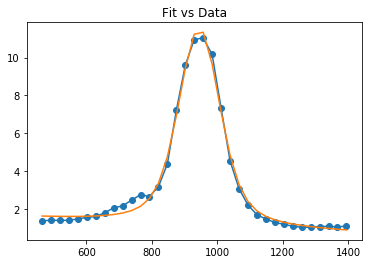

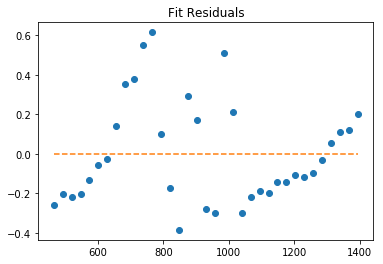

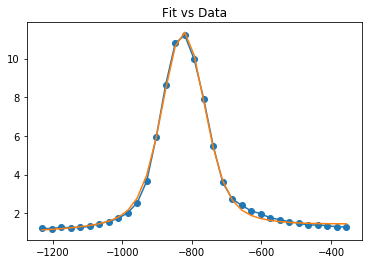

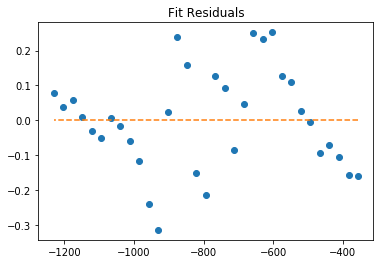

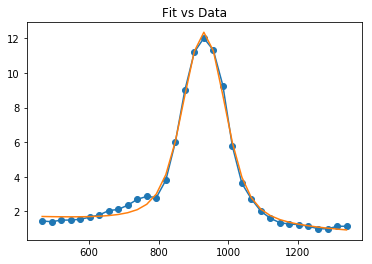

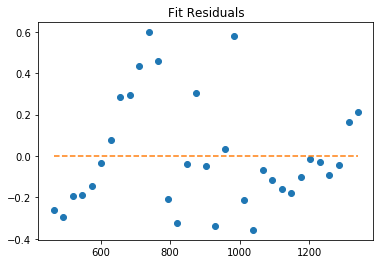

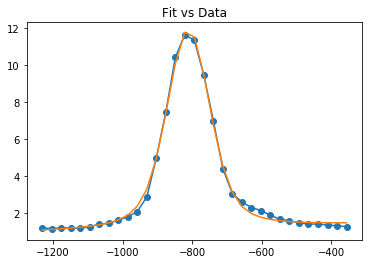

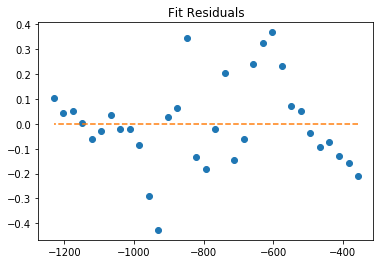

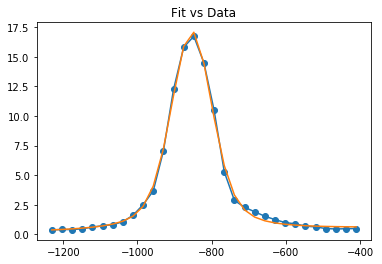

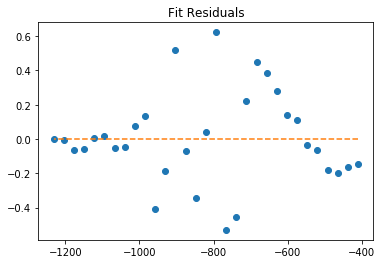

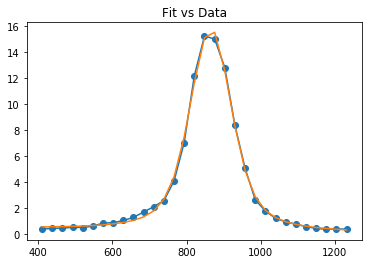

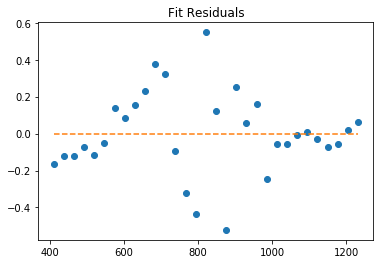

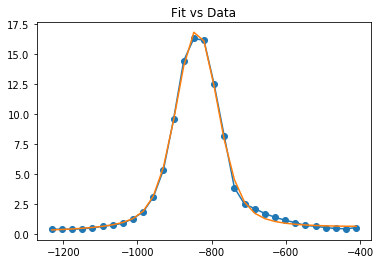

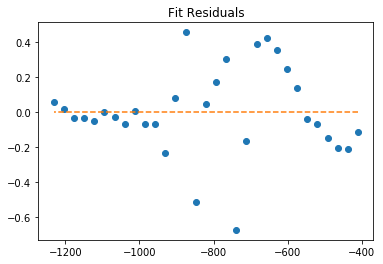

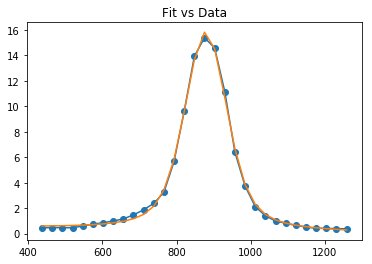

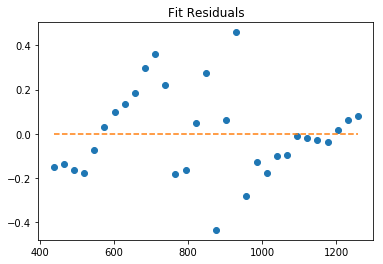

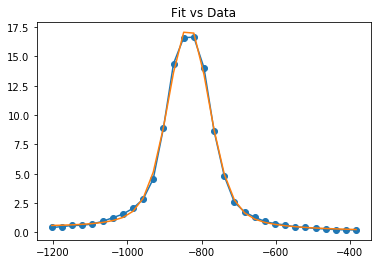

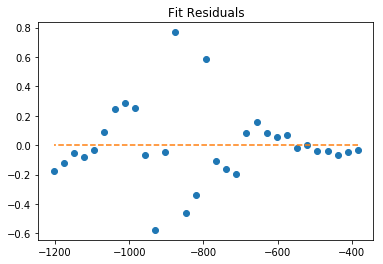

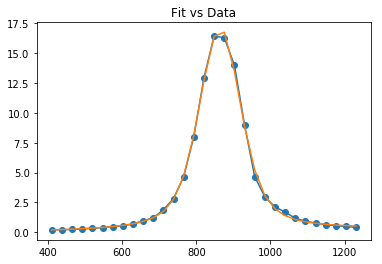

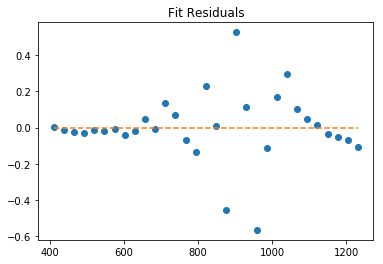

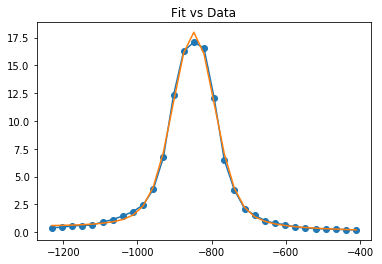

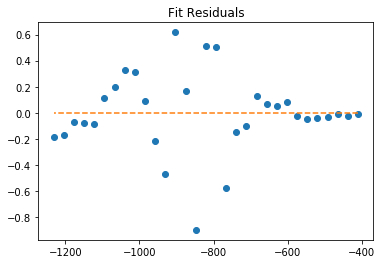

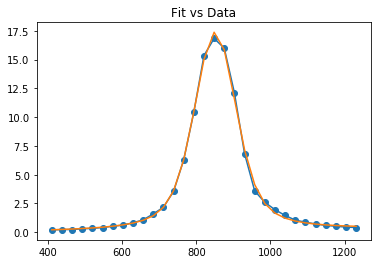

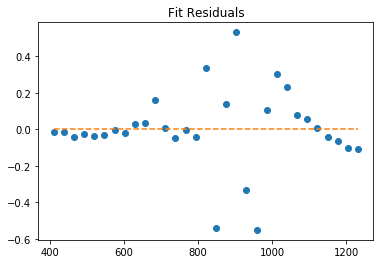

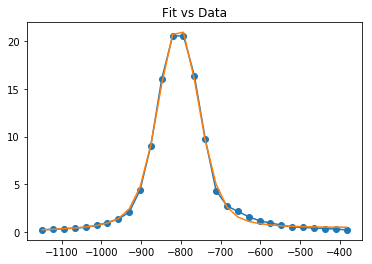

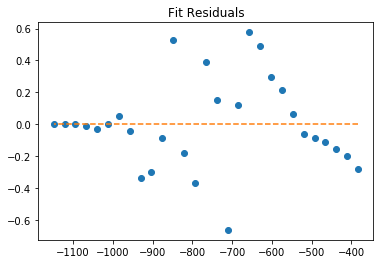

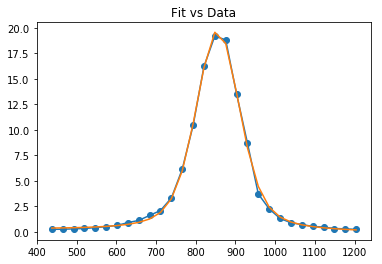

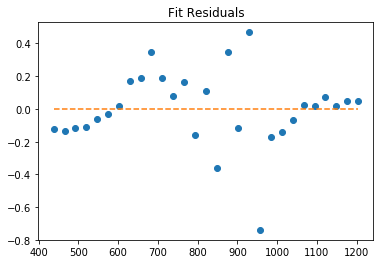

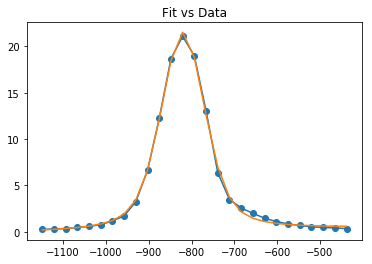

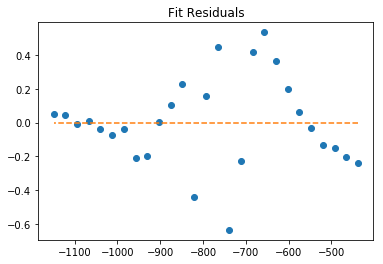

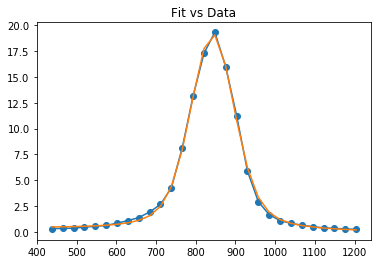

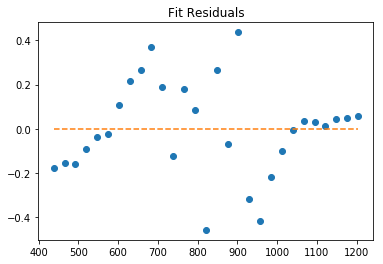

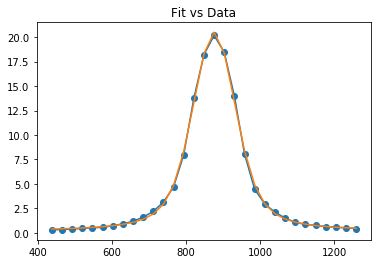

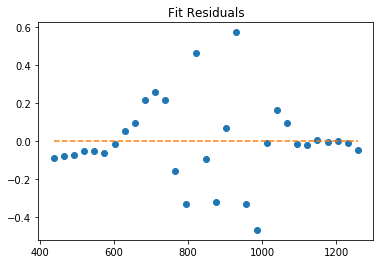

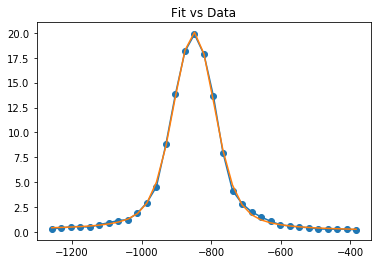

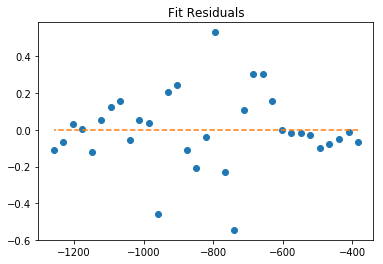

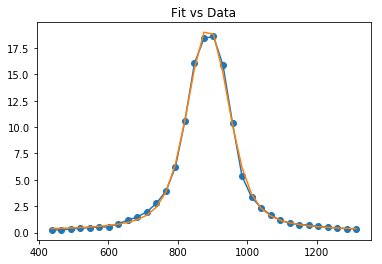

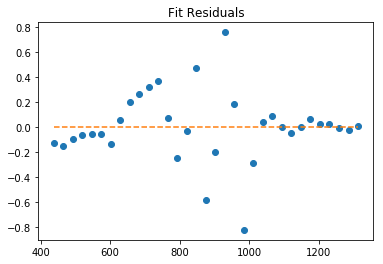

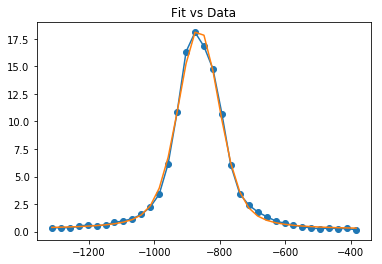

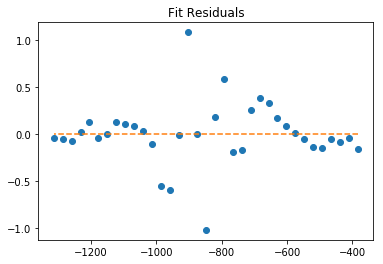

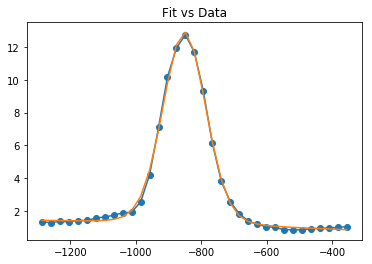

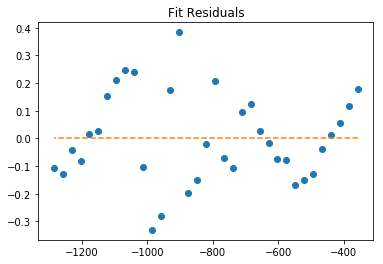

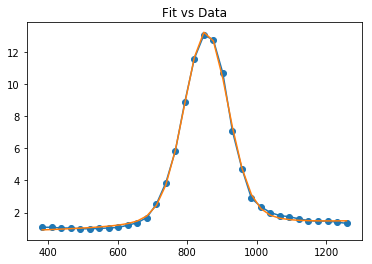

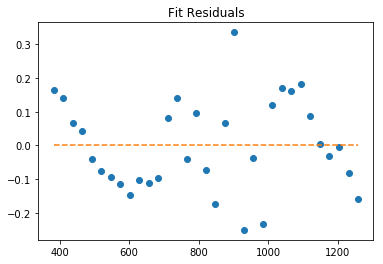

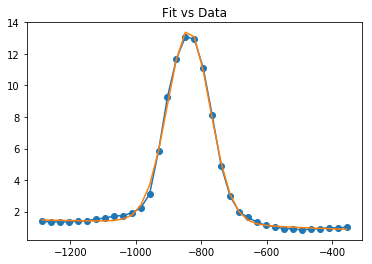

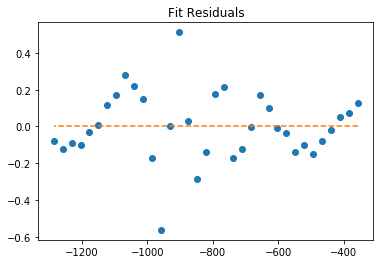

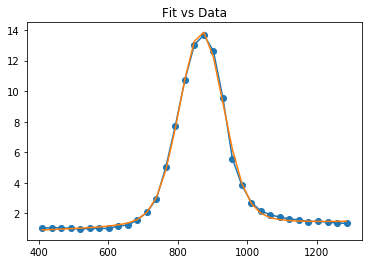

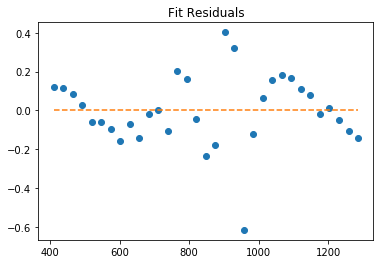

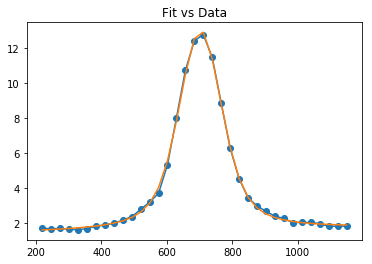

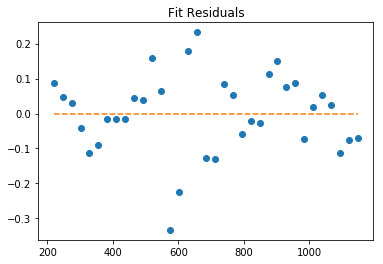

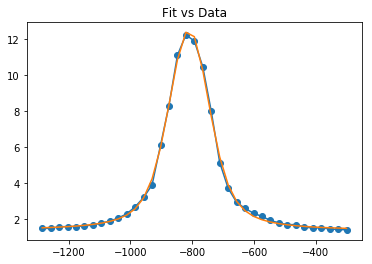

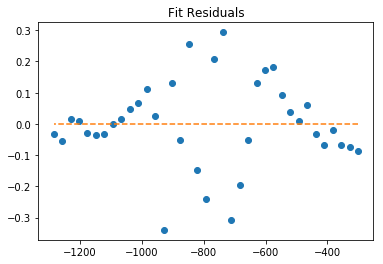

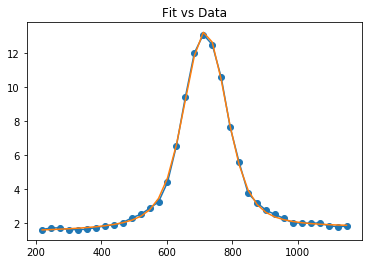

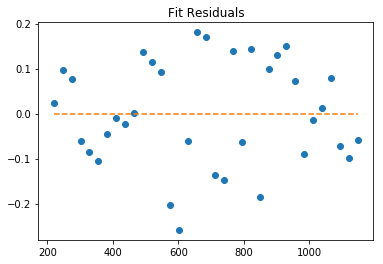

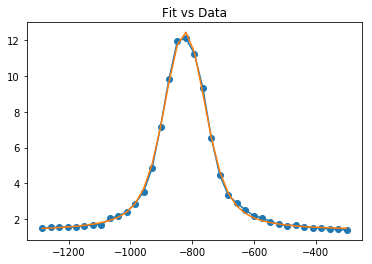

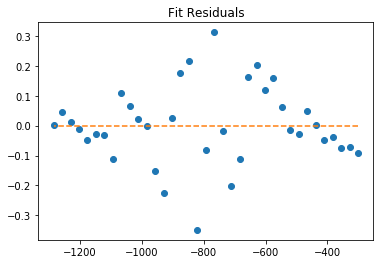

In [73]:
initial_up_arr =[
    False,True,False,False,False,True,False,True
]
speed = 19.52 #MHz/s
num_peaks = 2

YbOH = [] #blocked,unblocked
Yb = []
freq = []
enhancement = []
avg_freq = []

for i in range(len(initial_up_arr)):
    unblocked = ub_ODs[i]
    blocked = b_ODs[i]
    initial_up = initial_up_arr[i]
    ub_split= processBackAndForth(unblocked[1],unblocked[0],unblocked[2],speed,num_peaks,initial_up)
    b_split= processBackAndForth(blocked[1],blocked[0],blocked[2],speed,num_peaks,initial_up)
    [_YbOH_b,_Yb_b,_freq_b],[_YbOH_ub,_Yb_ub,_freq_ub] = matchBUB(b_split,ub_split)
    _en = []
    for _b_single,_ub_single,j in zip(_YbOH_b,_YbOH_ub,range(len(_YbOH_ub))):
        _en_single = calcEnhancement(_b_single,_ub_single)
        _en.append(_en_single)
        _bool = _en_single[_en_single<1]
        if list(_bool):
            print(_bool)
            print(i,j)
    enhancement.append(_en)
    YbOH.append([_YbOH_b,_YbOH_ub])
    Yb.append([_Yb_b,_Yb_ub])
    _avg = []
    for _b,_ub in zip(_freq_b,_freq_ub):
        _avg.append((_b+_ub)/2)
    freq.append([_freq_b,_freq_ub])
    avg_freq.append(_avg)
    
YbOH_c = YbOH
Yb_c = Yb
freq_c = freq
enhancement_c = enhancement
avg_freq_c = avg_freq

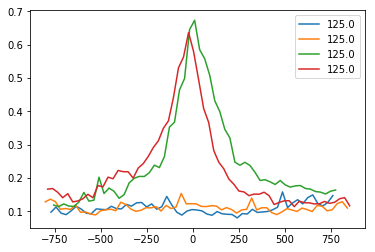

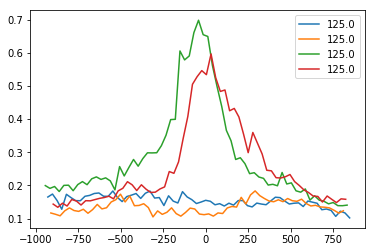

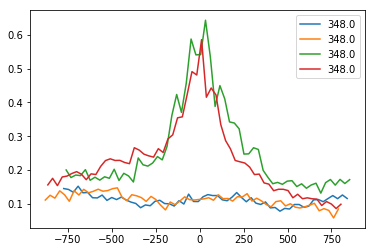

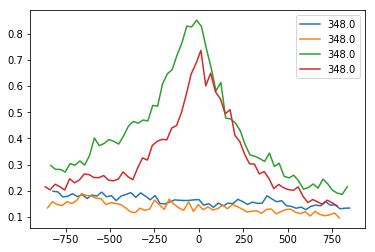

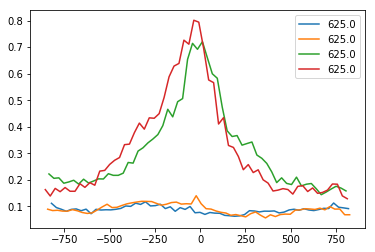

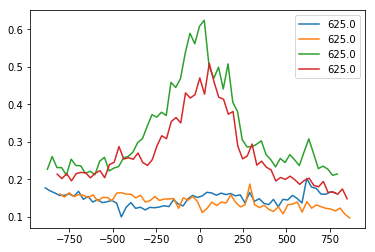

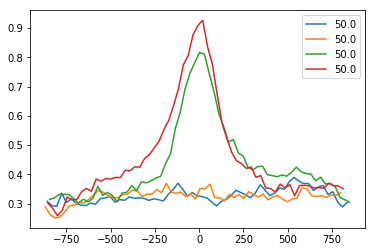

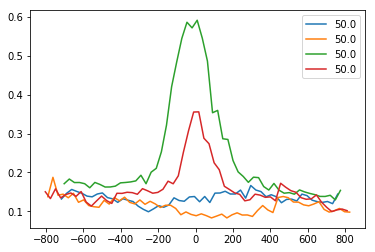

In [74]:
for _YbOH,_freq,_p in zip(YbOH,freq,powers_chirp):
    plt.figure()
    for _bub,_bubfreq in zip(_YbOH,_freq):
        for _trace,_x in zip(_bub,_bubfreq):
            plt.plot(_x,_trace,label=_p)
            plt.legend(loc='best')

In [76]:
def gaussianLinBG(x,a,b,n,m,c): # n exp(-(x-b)^2/(2a^2)) + m*x+c
    value= n*np.exp(-(x-b)**2/(2*a**2))+line(x,m,c)
    return value

def fitGaussianLinBG(xscale, data,guess=[100,0,0.16,0,0],sigma=None,plot=True,verbose=False):
    function = gaussianLinBG
    params,error,residuals = fitFunction(xscale,data,function,guess,sigma,plot)
    if verbose:
        print('\n')
        print('Fit error = ',error)
        print('FIT PARAMS = ',params)
        print('Mean = {} +/- {} MHz, StDev = {} +/- {} MHz'.format(params[1],error[1],params[0],error[0]))
    return [params,error,residuals]

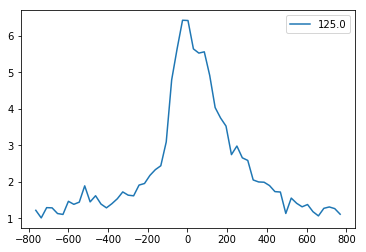

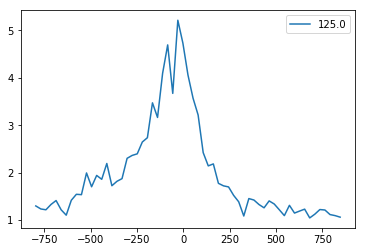

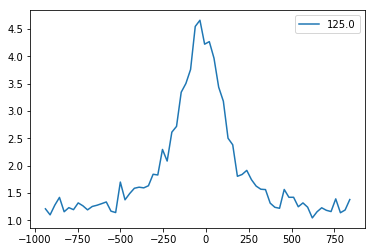

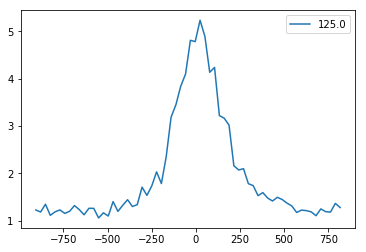

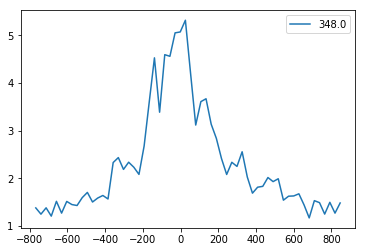

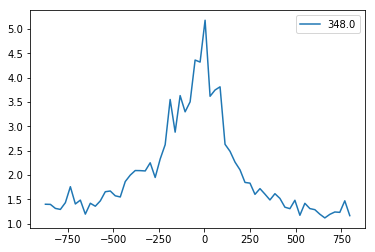

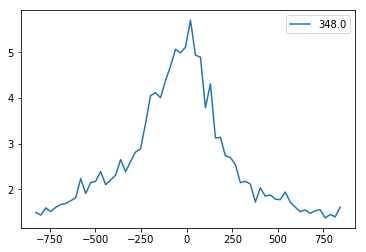

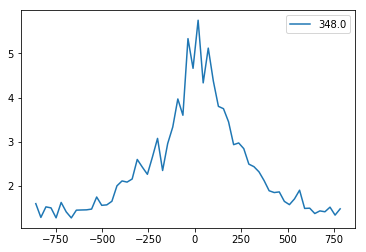

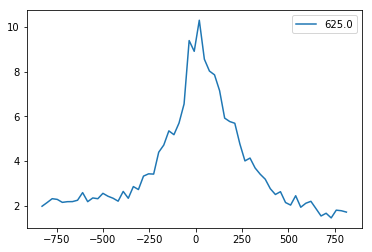

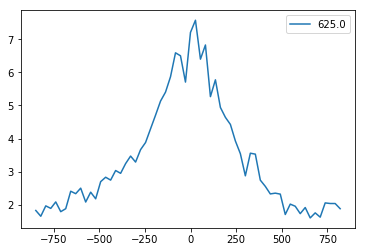

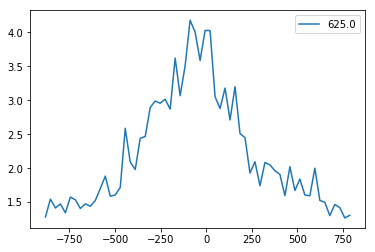

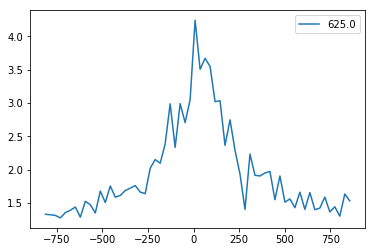

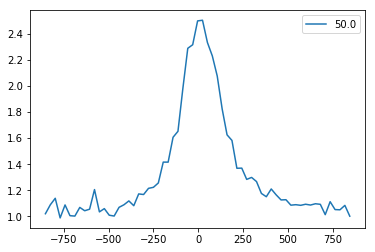

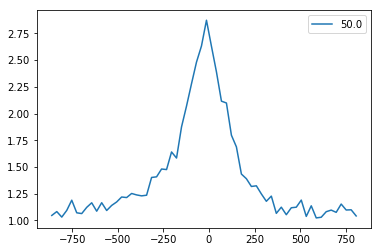

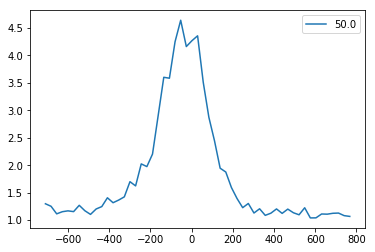

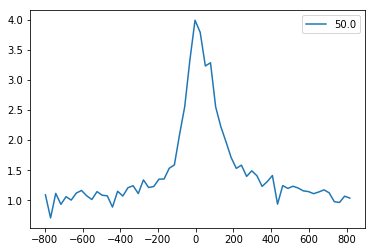

In [77]:
en_params = []
en_errors = []
for _en,_freq,_p in zip(enhancement,avg_freq,powers_chirp):
    #plt.figure(_p)
    #plt.title('Power = {} mW'.format(_p))
    #plt.xlabel('Detuning from 174Yb (MHz)')
    #plt.ylabel('Enhancement (OD Ratio)')
    _params = []
    _errors = []
    for _y,_x in zip(_en,_freq):
        loc,width,height = genGuessGaussian(_x,_y)
        guess = [width,loc,height,0,0]
        params,errors,resid = fitGaussianLinBG(_x,_y,guess,plot=False)
        plt.figure()
        plt.plot(_x,_y,label=_p)
        plt.legend(loc='best')
        #plt.figure(_p)
        #plt.plot(_x,gaussianLinBG(_x,*params))
        params[2]=params[2]+params[1]*params[3]+params[4]
        params = np.append(params,_y.max())
        _params.append(params)
        _errors.append(errors)
    en_params.append(_params)
    en_errors.append(_errors)

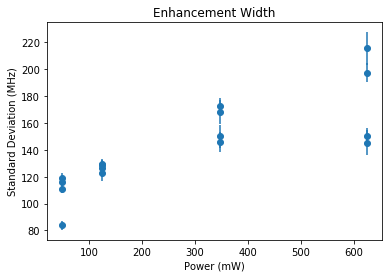

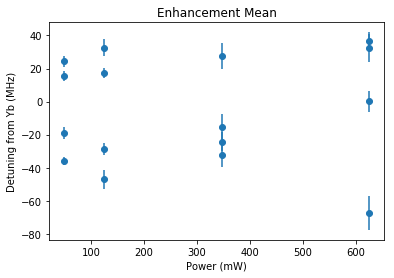

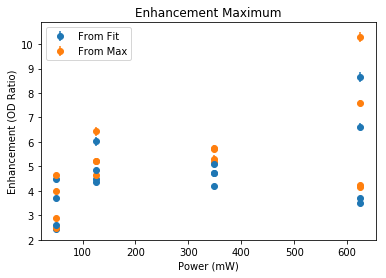

In [87]:
plt.figure(0)
plt.title('Enhancement Width'.format(_p))
plt.xlabel('Power (mW)')
plt.ylabel('Standard Deviation (MHz)')

plt.figure(1)
plt.title('Enhancement Mean'.format(_p))
plt.xlabel('Power (mW)')
plt.ylabel('Detuning from Yb (MHz)')

plt.figure(2)
plt.title('Enhancement Maximum'.format(_p))
plt.xlabel('Power (mW)')
plt.ylabel('Enhancement (OD Ratio)')

p_save = []
max_save = []
maxerr_save = []
width_save = []
widtherr_save = []

First = True
for _parray,_earray,_p in zip(en_params,en_errors,powers_chirp):
    color='C0'
    for _params,_errors in zip(_parray,_earray):
        p_save.append(_p)
        width_save.append(_params[0])
        widtherr_save.append(_errors[0])
        max_save.append(_params[2])
        maxerr_save.append(_errors[2])
        for i in range(3):
            plt.figure(i)
            if i==2:
                if First:
                    plt.errorbar(_p,_params[i],yerr=_errors[i],marker='o',linestyle='None',color=color,label='From Fit')
                    plt.errorbar(_p,_params[-1],yerr=_errors[i],marker='o',linestyle='None',color='C1',label='From Max')
                    plt.legend(loc='best')
                    First = False
                else:
                    plt.errorbar(_p,_params[i],yerr=_errors[i],marker='o',linestyle='None',color=color)
                    plt.errorbar(_p,_params[-1],yerr=_errors[i],marker='o',linestyle='None',color='C1')
            else:
                plt.errorbar(_p,_params[i],yerr=_errors[i],marker='o',linestyle='None',color=color)
save_data = np.array([np.array(p_save),np.array(max_save),np.array(maxerr_save),np.array(width_save),np.array(widtherr_save)])
lbls = ['Power (mW)', 'Maximum Enhancement', 'Max Error', 'Width (MHz)','Width Error (MHz)']

In [81]:
save_all = []
save_all.append(lbls)
for _arr in save_data.T:
    save_all.append(_arr)
writeCSVrows(save_all,'Processed_20190315/enhancement_max_width.csv')

Done! Array written to Processed_20190315/enhancement_max_width.csv


In [82]:
rows,header = readCSVcolumns('Processed_20190307/enhancement_max_width.csv',skip_header=1)
print(header)
powers_2 = rows[0]
max_2 = rows[1]
maxerr_2 = rows[2]
width_2 = rows[3]
widtherr_2 = rows[4]

Done! Array read from Processed_20190307/enhancement_max_width.csv
[['Power (mW)', 'Maximum Enhancement', 'Max Error', 'Width (MHz)', 'Width Error (MHz)']]


In [86]:
powers_chirp

array([125., 125., 348., 348., 625., 625.,  50.,  50.])

NameError: name 'p_save' is not defined

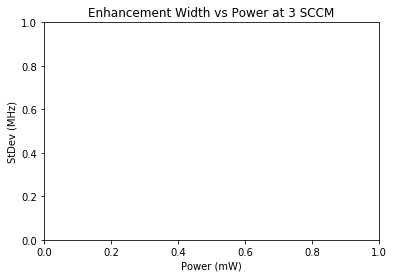

In [70]:
plt.figure()
plt.title('Enhancement Width vs Power at 3 SCCM')
plt.xlabel('Power (mW)')
plt.ylabel('StDev (MHz)')
plt.errorbar(p_save,width_save,yerr=widtherr_save,marker='o',linestyle='None',label='03152019')
plt.errorbar(powers_2,width_2,yerr=widtherr_2,marker='o',linestyle='None',label='03072019')
plt.legend(loc='best')

In [120]:
rows,header = readCSVcolumns('Processed_20190307/enhancement_max_width.csv',skip_header=1)
print(header)
powers_2 = rows[0]
max_2 = rows[1]
maxerr_2 = rows[2]
width_2 = rows[3]
widtherr_2 = rows[4]
rows,header = readCSVcolumns('Processed_20190313/avg_enhancement.csv',skip_header=1)
print(header)
powers_3 = rows[0]
max_3 = rows[1]
maxerr_3 = rows[2]
rows,header = readCSVcolumns('Processed_20190315/enhancement_max_width.csv',skip_header=1)
print(header)
powers_1 = rows[0]
max_1 = rows[1]
maxerr_1 = rows[2]
width_2 = rows[3]
widtherr_2 = rows[4]

Done! Array read from Processed_20190307/enhancement_max_width.csv
[['Power (mW)', 'Maximum Enhancement', 'Max Error', 'Width (MHz)', 'Width Error (MHz)']]
Done! Array read from Processed_20190313/avg_enhancement.csv
[['Power', 'Enhancement', 'Sigma']]
Done! Array read from Processed_20190315/enhancement_max_width.csv
[['Power (mW)', 'Maximum Enhancement', 'Max Error', 'Width (MHz)', 'Width Error (MHz)']]


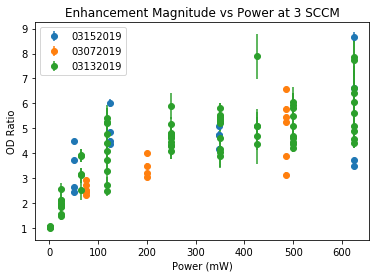

In [4]:
plt.figure()
plt.title('Enhancement Magnitude vs Power at 3 SCCM')
plt.xlabel('Power (mW)')
plt.ylabel('OD Ratio')
plt.errorbar(powers_1,max_1,yerr=maxerr_1,marker='o',linestyle='None',label='03152019')
plt.errorbar(powers_2,max_2,yerr=maxerr_2,marker='o',linestyle='None',label='03072019')
plt.errorbar(powers_3,max_3,yerr=maxerr_3,marker='o',linestyle='None',label='03132019')
plt.legend(loc='best')

In [121]:
lbls = ['Power (mW)', 'Maximum Enhancement', 'Max Error']
save_all = []
power_all = np.concatenate((powers_1,powers_2,powers_3))
max_all = np.concatenate((max_1,max_2,max_3))
maxerr_all = np.concatenate((maxerr_1,maxerr_2,maxerr_3))
save_data = np.array([power_all,max_all,maxerr_all])
save_all.append(lbls)
for _arr in save_data.T:
    save_all.append(_arr)
writeCSVrows(save_all,'Processed_20190315/enhancement_max_0307_0313_0315.csv')

Done! Array written to Processed_20190315/enhancement_max_0307_0313_0315.csv


<ErrorbarContainer object of 3 artists>

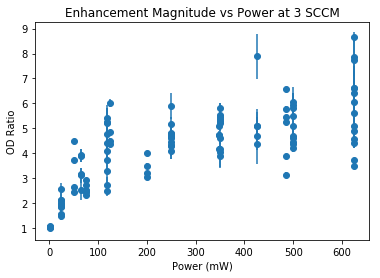

In [77]:
plt.figure()
plt.title('Enhancement Magnitude vs Power at 3 SCCM')
plt.xlabel('Power (mW)')
plt.ylabel('OD Ratio')
plt.errorbar(power_all,max_all,yerr=maxerr_all,marker='o',linestyle='None')

In [2]:
def dopplerPowerExcitedFraction(I,N,T):
    Isat = 0.04626 #mW/cm^2
    gamma = 0.1823 #MHz
    doppler = 33.58*np.sqrt(T) #MHz/sqrt(Kelvin)
    s = I/Isat
    N_excited = N * s/np.sqrt(1+s) * gamma/doppler
    return 1+N_excited
def powerIntensity(ptot,d=0.5):
    #assuming gaussian beam
    #diameter d is in cm, ptot is in mW
    I = 2*ptot/(np.pi * (d/2)**2)
    return I #mW/cm^2
def fitDopplerPower(xscale,data,guess=[1,4],sigma=None,bounds=None,plot=True):
    bounds=([0,4],[np.inf,np.inf])
    function = dopplerPowerExcitedFraction
    params,error,residuals = fitFunction(xscale,data,function,guess,sigma,plot,bounds)
    return [params,error,residuals]

In [124]:
max_sort = np.array(sortData(power_all,max_all))
maxerr_sort = np.array(sortData(power_all,maxerr_all))
power_sort = np.array(sorted(power_all))

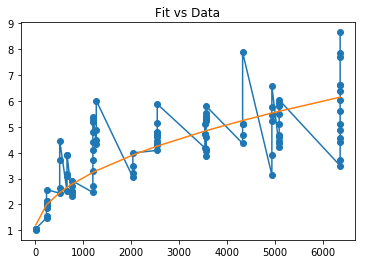

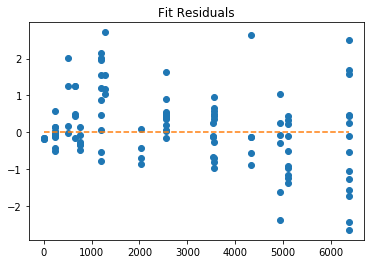

In [125]:
intensity_all = powerIntensity(power_sort)
params,error,residuals=fitDopplerPower(intensity_all,max_sort)

<ErrorbarContainer object of 3 artists>

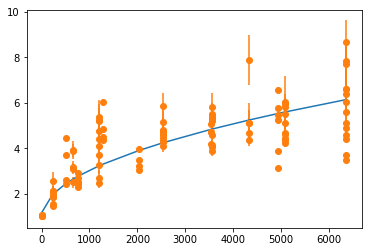

In [126]:
plt.plot(intensity_all,dopplerPowerExcitedFraction(intensity_all,*params))
plt.errorbar(intensity_all,max_sort,yerr=maxerr_sort,marker='o',linestyle='None')

In [99]:
def dopplerPowerExcitedFraction(I,N,T):
    Isat = 0.04626 #mW/cm^2
    gamma = 0.1823 #MHz
    doppler = 33.58*np.sqrt(T) #MHz/sqrt(Kelvin)
    s = I/Isat
    N_excited = N * s/np.sqrt(1+s) * gamma/doppler
    return 1+N_excited
def powerIntensity(ptot,d=0.3):
    #assuming gaussian beam
    #diameter d is in cm, ptot is in mW
    I = 2*ptot/(np.pi * (d/2)**2)
    return I #mW/cm^2
def fitDopplerPower(xscale,data,guess=[1,4],sigma=None,bounds=None,plot=True):
    bounds=([0,4],[np.inf,np.inf])
    function = dopplerPowerExcitedFraction
    params,error,residuals = fitFunction(xscale,data,function,guess,sigma,plot,bounds)
    return [params,error,residuals]

def voigtLineshape(x,lor_fwhm,gauss_stdev):
    max_value = voigt(x,lor_fwhm/2,gauss_stdev,0,1,0)
    return max_value
def voigtExcitedFraction(I,N):
    Isat = 0.04626 #mW/cm^2
    s = I/Isat
    lor_fwhm = 0.1823*np.sqrt(1+s) #MHz
    T=4
    gauss_stdev = 11.87 *np.sqrt(T) #MHz/sqrt(Kelvin)
    N_excited = np.zeros(len(I))
    for _lor,i in zip(lor_fwhm,range(len(I))):
        x,dx = np.linspace(-_lor/2,_lor/2,num=100,retstep=True)
        N_excited[i] = N * voigtLineshape(x,_lor,gauss_stdev).sum()*dx
    return N_excited
def voigtExcitedFraction2(I,N):
    Isat = 0.04626 #mW/cm^2
    s = I/Isat
    lor_fwhm = 0.1823*np.sqrt(1+s) #MHz
    T=4
    gauss_stdev = 11.87 *np.sqrt(T) #MHz/sqrt(Kelvin)
    N_excited = N * voigtLineshape(0,lor_fwhm,gauss_stdev)*lor_fwhm
    return 1+N_excited
def fitVoigtDopplerPower(xscale,data,guess=1,sigma=None,bounds=None,plot=True):
    function = 1+voigtExcitedFraction
    params,error,residuals = fitFunction(xscale,data,function,guess,sigma,plot,bounds)
    return [params,error,residuals]
def fitCrossSection(xscale,data,guess=[1,1],sigma=None,bounds=None,plot=True):
    function = excitedFraction
    bounds = ([0,0],[np.inf,np.inf])
    params,error,residuals = fitFunction(xscale,data,function,guess,sigma,plot,bounds)
    return [params,error,residuals]
def _voigt(x,lor,sig,mean=0,n=1,c=0): #lor = hwhm, sigma = gaussian stdev
    z= ((x-mean) + 1j*lor)/(sig*np.sqrt(2))
    value = n*np.real(wofz(z))/(sig*np.sqrt(2*np.pi))+c
    return value
def excitedFraction(I,N,a):
    Isat = 0.13878 #mW/cm^2
    s = I/Isat*a
    gamma = 1.145 #MHz*2pi
    lor_hwhm = gamma*np.sqrt(1+s)/2
    gauss_sig = 149.17 #MHz*2pi
    rhoee = np.pi*(s/4)/np.sqrt(1+s)*gamma * _voigt(0,lor_hwhm,gauss_sig)
    return 1+N*rhoee
def voigtWidth(I,N,a,T):
    Isat = 0.13878 #mW/cm^2
    s = I/Isat*a
    gamma = 1.145 #MHz*2pi
    lor_hwhm = gamma*np.sqrt(1+s)/2
    gauss_sig = 149.17/np.sqrt(4)*np.sqrt(T) #MHz*2pi
    lorMHz = lor_hwhm/(2*np.pi)
    gaussMHz = gauss_sig/(2*np.pi)
    freqMHz = np.linspace(-500,500,num=10000)
    fwhm = []
    for lor in lorMHz:
        fwhm.append(findFWHM(freqMHz, _voigt(freqMHz,lor,gaussMHz)))
    fwhm = np.array(fwhm)
    stdev = fwhm/(2*np.sqrt(2*np.log(2)))
    return N*stdev
def fitVoigtWidth(xscale,data,guess=[4,1,4],sigma=None,bounds=None,plot=True):
    function = voigtWidth
    bounds = ([0,0,0],[np.inf,np.inf,30])
    params,error,residuals = fitFunction(xscale,data,function,guess,sigma,plot,bounds)
    return [params,error,residuals]

def findNearestIdx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def lorentzian(x,lor): #lor = hwhm
    f = 1/np.pi * lor/(x**2 + lor**2)
    return f

def gaussian(x,sig):
    f = 1/np.sqrt(2*np.pi*sig**2)*np.exp(-x**2/(2*sig**2))
    return f

def findFWHM(x,data):
    half_max = data.max()/2
    idx_max = np.argmax(data)
    data_L = data[0:idx_max]
    x_L = x[0:idx_max]
    data_R = data[idx_max:]
    x_R = x[idx_max:]
    half_L = x_L[findNearestIdx(data_L,half_max)]
    half_R = x_R[findNearestIdx(data_R,half_max)]
    FWHM = abs(half_R-half_L)
    return FWHM
    

Text(0.5, 0, 'Power (mW)')

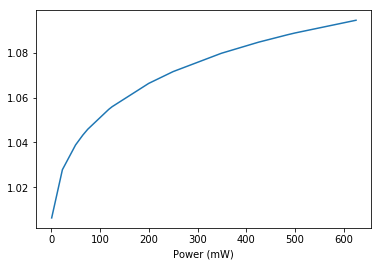

In [179]:
plt.plot(power_sort,excitedFraction(intensity_all,1))
plt.xlabel('Power (mW)')

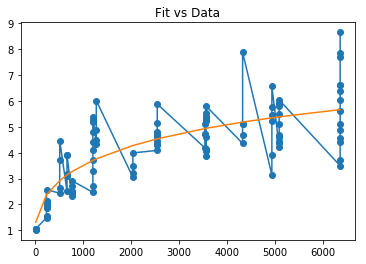

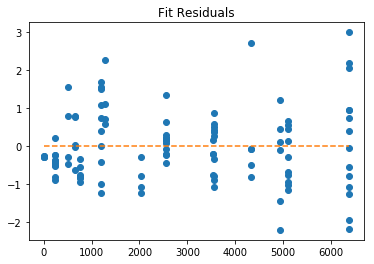

In [180]:
intensity_all = powerIntensity(power_sort)
params,error,residuals=fitCrossSection(intensity_all,max_sort)

Text(0, 0.5, 'Integrated OD Ratio')

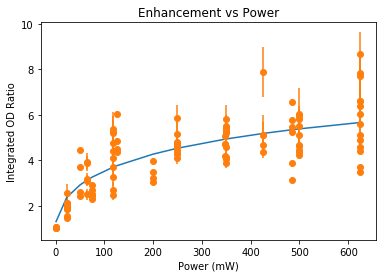

In [181]:
plt.plot(power_sort,excitedFraction(intensity_all,*params))
plt.errorbar(power_sort,max_sort,yerr=maxerr_sort,marker='o',linestyle='None')
plt.xlabel('Power (mW)')
plt.title('Enhancement vs Power')
plt.ylabel('Integrated OD Ratio')

In [139]:
rows,header = readCSVcolumns('Processed_20190307/enhancement_max_width.csv',skip_header=1)
print(header)
powers_2 = rows[0]
max_2 = rows[1]
maxerr_2 = rows[2]
width_2 = rows[3]
widtherr_2 = rows[4]
rows,header = readCSVcolumns('Processed_20190313/avg_enhancement.csv',skip_header=1)
print(header)
powers_3 = rows[0]
max_3 = rows[1]
maxerr_3 = rows[2]
rows,header = readCSVcolumns('Processed_20190315/enhancement_max_width.csv',skip_header=1)
print(header)
powers_1 = rows[0]
max_1 = rows[1]
maxerr_1 = rows[2]
width_1 = rows[3]
widtherr_1 = rows[4]

Done! Array read from Processed_20190307/enhancement_max_width.csv
[['Power (mW)', 'Maximum Enhancement', 'Max Error', 'Width (MHz)', 'Width Error (MHz)']]
Done! Array read from Processed_20190313/avg_enhancement.csv
[['Power', 'Enhancement', 'Sigma']]
Done! Array read from Processed_20190315/enhancement_max_width.csv
[['Power (mW)', 'Maximum Enhancement', 'Max Error', 'Width (MHz)', 'Width Error (MHz)']]


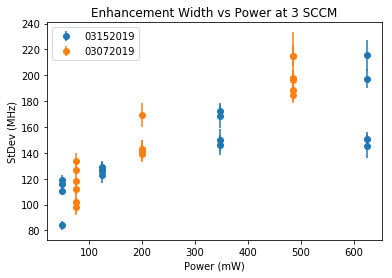

In [197]:
plt.figure()
plt.title('Enhancement Width vs Power at 3 SCCM')
plt.xlabel('Power (mW)')
plt.ylabel('StDev (MHz)')
plt.errorbar(powers_1,width_1,yerr=widtherr_1,marker='o',linestyle='None',label='03152019')
plt.errorbar(powers_2,width_2,yerr=widtherr_2,marker='o',linestyle='None',label='03072019')
plt.legend(loc='best')

In [183]:
lbls = ['Power (mW)', 'Enhancement StDev (MHz)', 'Width Error (MHz)']
save_all = []
power_all = np.concatenate((powers_1,powers_2))
width_all = np.concatenate((width_1,width_2))
widtherr_all = np.concatenate((widtherr_1,widtherr_2))
save_data = np.array([power_all,width_all,widtherr_all])
save_all.append(lbls)
for _arr in save_data.T:
    save_all.append(_arr)
writeCSVrows(save_all,'Processed_20190315/enhancement_width_0307_0315.csv')

Done! Array written to Processed_20190315/enhancement_width_0307_0315.csv


In [184]:
width_sort = np.array(sortData(power_all,width_all))
widtherr_sort = np.array(sortData(power_all,widtherr_all))
power_sort2 = np.array(sorted(power_all))

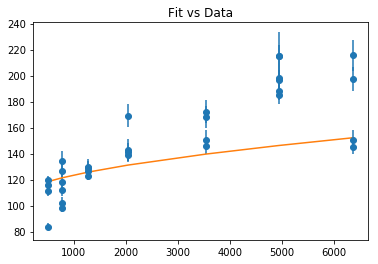

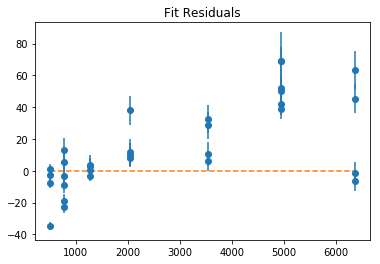

In [198]:
intensity_all2 = powerIntensity(power_sort2)
params,error,residuals=fitVoigtWidth(intensity_all2,width_sort,sigma=list(widtherr_sort))

Text(0, 0.5, 'Enhancement StDev (MHz)')

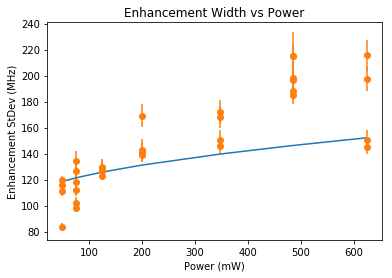

In [199]:
plt.plot(power_sort2,voigtWidth(intensity_all2,*params))
plt.errorbar(power_sort2,width_sort,yerr=widtherr_sort,marker='o',linestyle='None')
plt.xlabel('Power (mW)')
plt.title('Enhancement Width vs Power')
plt.ylabel('Enhancement StDev (MHz)')

In [148]:
def rho(d,s):
    gamma = 0.182 #kHz
    rhoee=s/2/(1+s+(2*d/gamma)**2)
    return rhoee

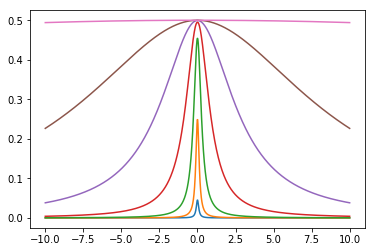

In [156]:
f = np.linspace(-10,10,num=1000)
sval = [0.1,1,10,100,1000,10000,1000000]
plt.figure()
for s in sval:
    plt.plot(f,rho(f,s))

In [5]:
results=readCSVcolumns('Processed_20190315/enhancement_max_0307_0313_0315.csv',skip_header=1)
header = results[1]
print(header)
[power,en,en_err] = results[0]

Done! Array read from Processed_20190315/enhancement_max_0307_0313_0315.csv
[['Power (mW)', 'Maximum Enhancement', 'Max Error']]


<ErrorbarContainer object of 3 artists>

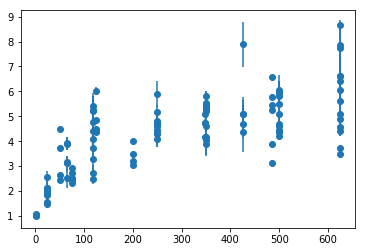

In [10]:
plt.errorbar(power,en,yerr=en_err,marker='o',linestyle='None')

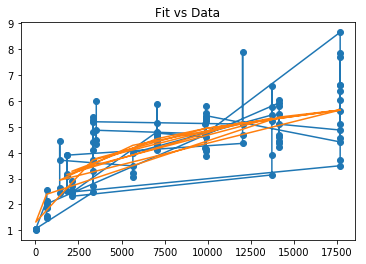

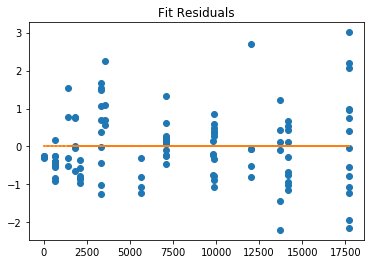

In [42]:
intensity = powerIntensity(power)
params,error,residuals=fitCrossSection(intensity,en)
power_sort = np.array(sorted(power))
intensity_sort = powerIntensity(power_sort)

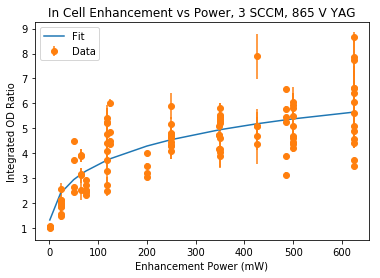

In [59]:
f=plt.figure(figsize=(6,4))
plt.plot(power_sort,excitedFraction(intensity_sort,*params),label='Fit')
plt.errorbar(power,en,yerr=en_err,marker='o',linestyle='None',label='Data')
plt.xlabel('Enhancement Power (mW)')
plt.title('In Cell Enhancement vs Power, 3 SCCM, 865 V YAG')
plt.ylabel('Integrated OD Ratio')
plt.legend(loc='best')
plt.savefig('Enhancement_v_Power_3SCCM_865V.svg',format='svg')

In [85]:
results=readCSVcolumns('Processed_20190315/enhancement_width_0307_0315.csv',skip_header=1)
header = results[1]
print(header)
[power,w,w_err] = results[0]

Done! Array read from Processed_20190315/enhancement_width_0307_0315.csv
[['Power (mW)', 'Enhancement StDev (MHz)', 'Width Error (MHz)']]


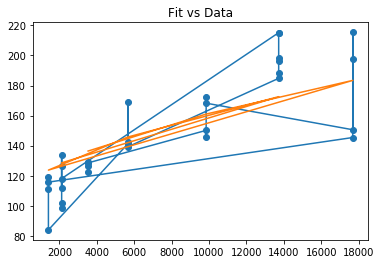

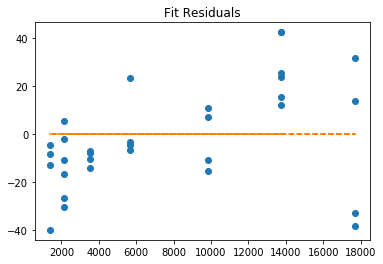

In [100]:
intensity = powerIntensity(power)
params,error,residuals=fitVoigtWidth(intensity,w)
power_sort = np.array(sorted(power))
intensity_sort = powerIntensity(power_sort)

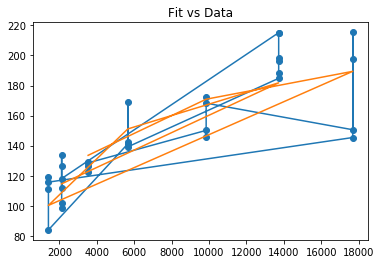

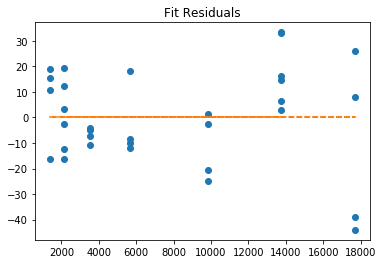

In [105]:
intensity = powerIntensity(power)
params,error,residuals=fitCrossSection(intensity,w)
power_sort = np.array(sorted(power))
intensity_sort = powerIntensity(power_sort)

<ErrorbarContainer object of 3 artists>

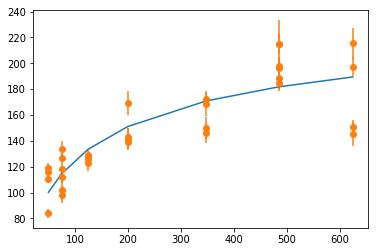

In [108]:
plt.plot(power_sort,excitedFraction(intensity_sort,*params),label='Fit')
plt.errorbar(power,w,yerr=w_err,marker='o',linestyle='None',label='Data')

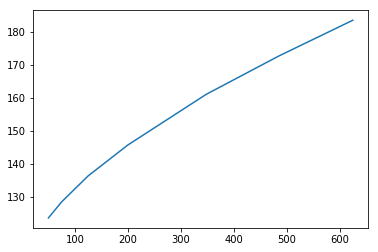

In [104]:
plt.plot(power_sort,voigtWidth(intensity_sort,*params),label='Fit')

Now let's do analysis of the resonant data

In [109]:
params

array([470.013914,   1.49417 ])

In [94]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import statistics as stat
from enhancement_analysis import *
from fit_functions import *
from low_level import readCSVrows,writeCSVrows,calcEnhancement,readCSVcolumns
%matplotlib inline

In [96]:
results=readCSVcolumns('Processed_20190315/data_legend_nogas.csv',skip_header=1)
header = results[1]
print(header)
[powers,starts,stops]= results[0]

Done! Array read from Processed_20190315/data_legend_nogas.csv
[['ï»¿Power (mW)', 'Start', 'Stop']]


FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

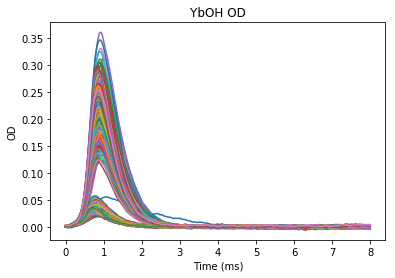

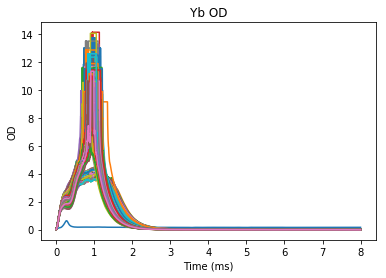

In [97]:
folder = '20190315'
skips = []
ABAB = True

start_arr = starts.astype(int)
stop_arr = stops.astype(int)
power_arr = powers

enhancement = []

b_ODs = []
ub_ODs = []

for _start,_stop in zip(start_arr,stop_arr):
    
    ODs_1 = calculateSeriesOD(folder,_start,_stop,skips,ABAB=ABAB)
    ODs_2 = calculateSeriesOD(folder,_start+1,_stop,skips,ABAB=ABAB)
    
    p_1 = processData(ODs_1,[0,8])
    p_2 = processData(ODs_2,[0,8])
    b,ub = identifyBUB(p_1,p_2,equal=True)
    en = calcEnhancement(b[0],ub[0])
    enhancement.append(en)
    b_ODs.append(b)
    ub_ODs.append(ub)
#p=YbOH integrated, Yb integrated, timestamp

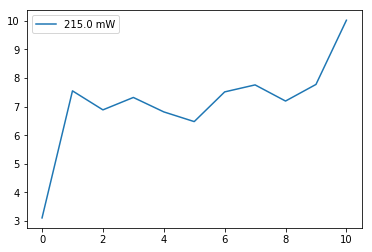

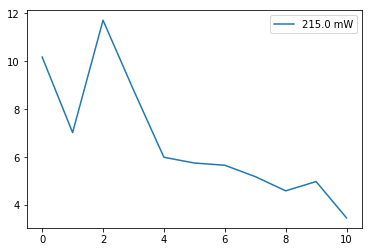

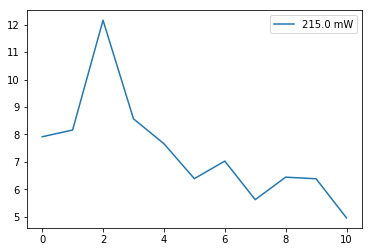

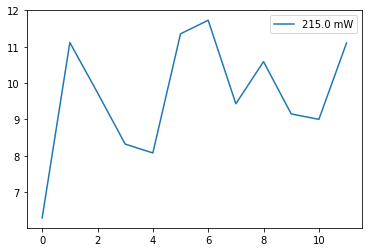

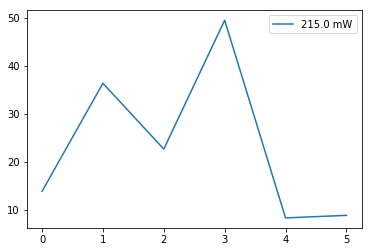

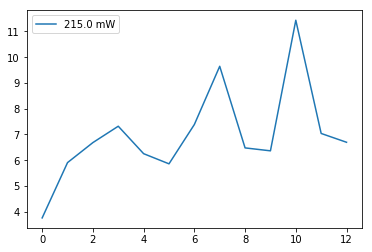

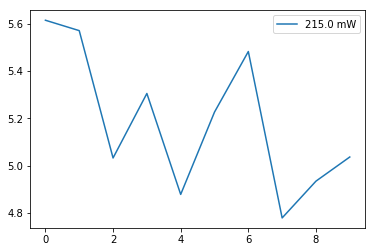

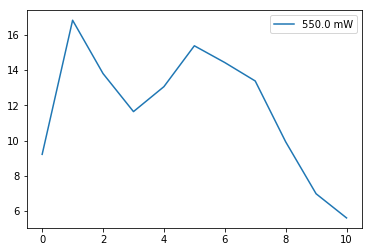

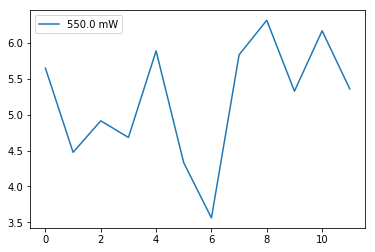

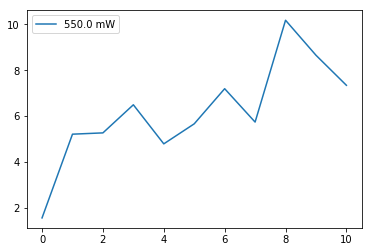

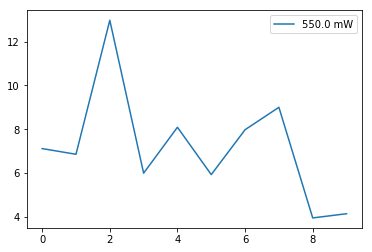

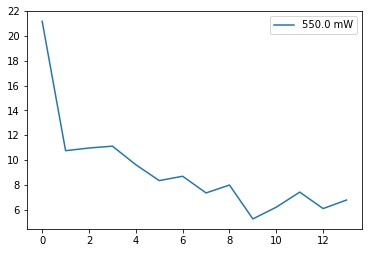

In [98]:
avg = []
err = []
for _en,_p in zip(enhancement,powers):
    plt.figure()
    plt.plot(_en,label='{} mW'.format(_p))
    plt.legend(loc='best')
    avg.append(np.array(_en).mean())
    err.append(np.array(_en).std())

<ErrorbarContainer object of 3 artists>

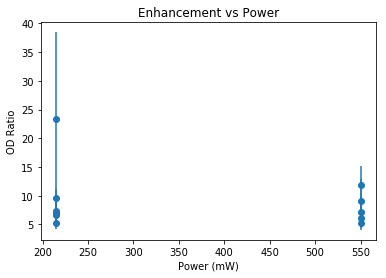

In [99]:
plt.figure()
plt.title('Enhancement vs Power')
plt.xlabel('Power (mW)')
plt.ylabel('OD Ratio')
plt.errorbar(powers,avg,yerr=err,marker='o',linestyle='None')

Now to do with gas

In [100]:
results=readCSVcolumns('Processed_20190315/data_legend_resgas.csv',skip_header=1)
header = results[1]
print(header)
[powers,starts,stops]= results[0]

Done! Array read from Processed_20190315/data_legend_resgas.csv
[['ï»¿Power (mW)', 'Start', 'Stop']]


FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

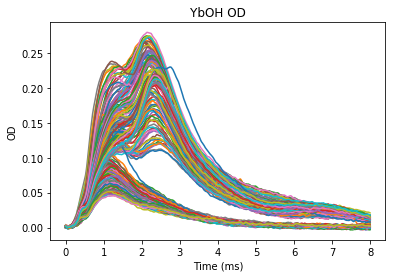

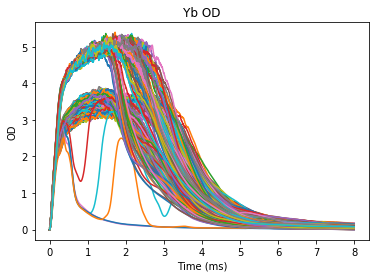

In [101]:
folder = '20190315'
skips = []
ABAB = True

start_arr = starts.astype(int)
stop_arr = stops.astype(int)
power_arr = powers

enhancement = []

b_ODs = []
ub_ODs = []

for _start,_stop in zip(start_arr,stop_arr):
    
    ODs_1 = calculateSeriesOD(folder,_start,_stop,skips,ABAB=ABAB)
    ODs_2 = calculateSeriesOD(folder,_start+1,_stop,skips,ABAB=ABAB)
    
    p_1 = processData(ODs_1,[0,8])
    p_2 = processData(ODs_2,[0,8])
    b,ub = identifyBUB(p_1,p_2,equal=True)
    en = calcEnhancement(b[0],ub[0])
    enhancement.append(en)
    b_ODs.append(b)
    ub_ODs.append(ub)
#p=YbOH integrated, Yb integrated, timestamp

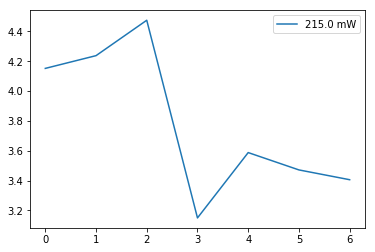

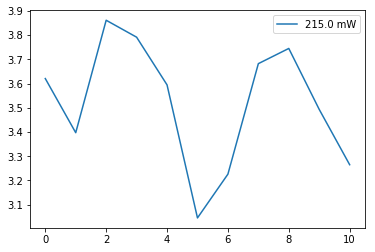

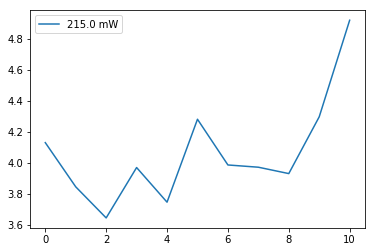

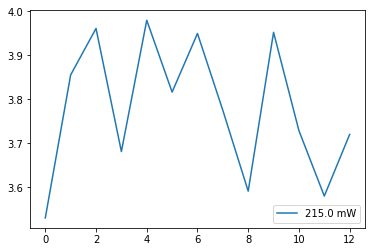

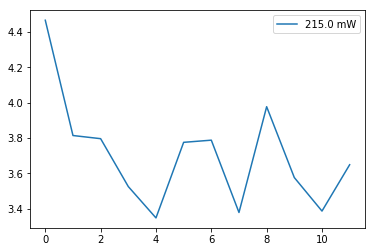

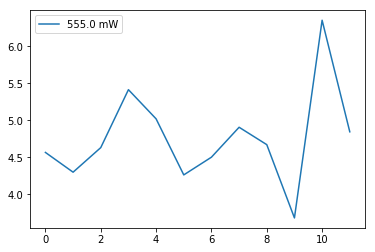

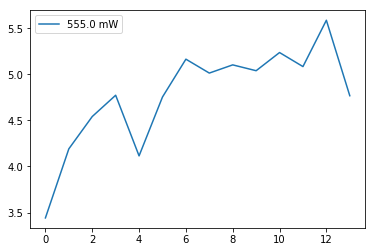

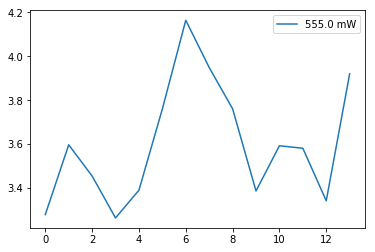

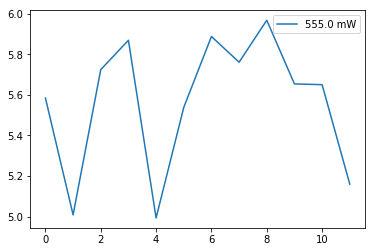

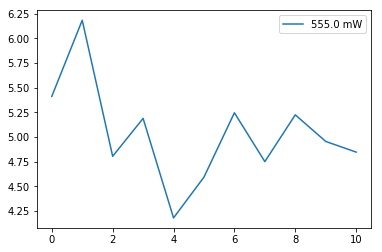

In [102]:
avg = []
err = []
for _en,_p in zip(enhancement,powers):
    plt.figure()
    plt.plot(_en,label='{} mW'.format(_p))
    plt.legend(loc='best')
    avg.append(np.array(_en).mean())
    err.append(np.array(_en).std())

<ErrorbarContainer object of 3 artists>

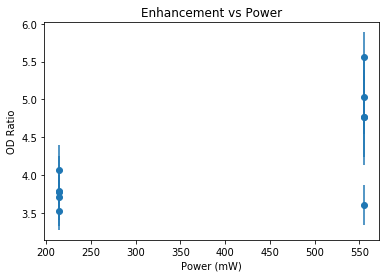

In [103]:
plt.figure()
plt.title('Enhancement vs Power')
plt.xlabel('Power (mW)')
plt.ylabel('OD Ratio')
plt.errorbar(powers,avg,yerr=err,marker='o',linestyle='None')